In [1]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import zipfile

2025-06-04 23:28:54.265394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749079734.540214      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749079734.620295      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load generator
G = tf.keras.models.load_model('/kaggle/input/monet_generator_scm1/keras/default/1/monet_generator.keras')

2025-06-04 23:29:12.436309: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
from tqdm.notebook import tqdm
import io

# Decode and preprocess function
def decode_image(example):
    features = {"image": tf.io.FixedLenFeature([], tf.string)}
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Load photos from TFRecord
photo_paths = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')
photo_ds = tf.data.TFRecordDataset(photo_paths).map(decode_image).take(7028)

# Generate Monet-style images with progress bar
print("Generating Monet-style images...")
# Create zip and write images directly (no disk output!)
with zipfile.ZipFile("images.zip", "w") as zipf:
    for i, img in tqdm(enumerate(photo_ds), total=7028):
        # Run generator
        generated = G(tf.expand_dims(img, 0), training=False)[0]
        generated = (generated + 1.0) * 127.5
        generated = tf.clip_by_value(generated, 0, 255)
        arr = tf.cast(generated, tf.uint8).numpy()

        # Convert to JPEG in-memory
        buffer = io.BytesIO()
        Image.fromarray(arr).save(buffer, format='JPEG')
        buffer.seek(0)

        # Write to zip (no intermediate files!)
        zipf.writestr(f"{i}.jpg", buffer.read())

print("✅ Done! images.zip is ready for submission.")

Generating Monet-style images...


  0%|          | 0/7028 [00:00<?, ?it/s]

✅ Done! images.zip is ready for submission.


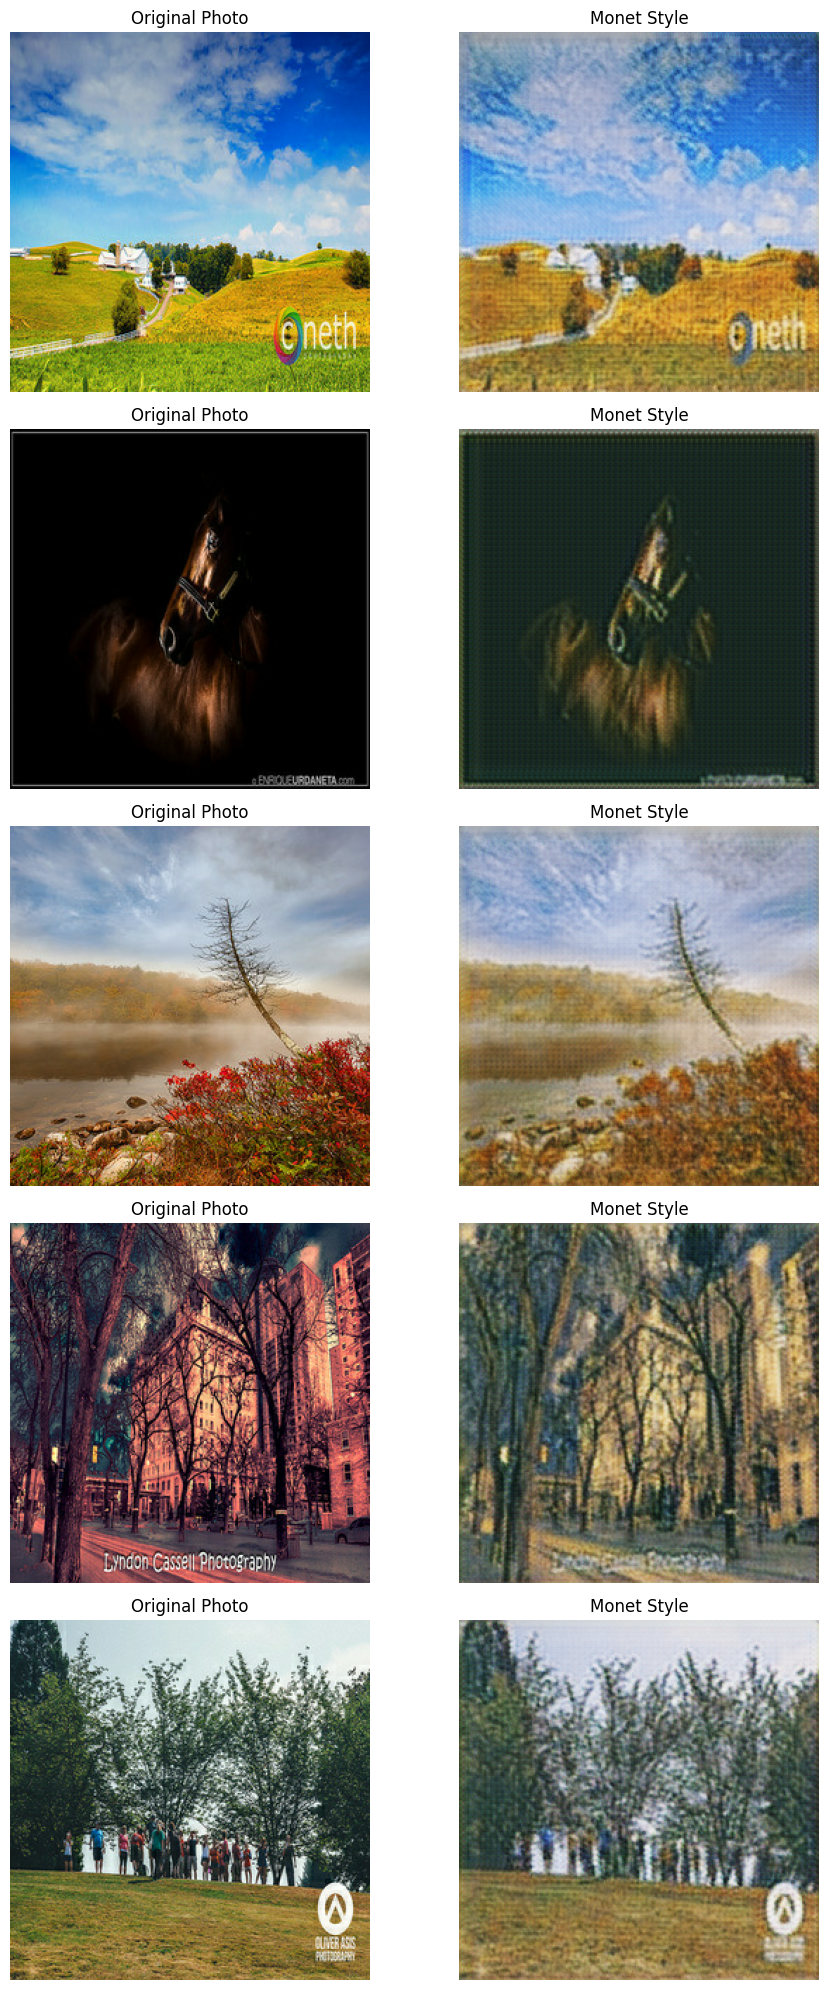

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

# Decode and preprocess image
def decode_image(example):
    features = {"image": tf.io.FixedLenFeature([], tf.string)}
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Load the TFRecord dataset
photo_paths = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')
photo_ds = tf.data.TFRecordDataset(photo_paths).map(decode_image)

# Convert to list to sample randomly (only safe since we have enough memory)
photo_images = list(photo_ds.take(1000))  # Load first 1000 images only to keep things efficient

# Select N random images
N = 5
samples = random.sample(photo_images, N)

# Plot
plt.figure(figsize=(10, 4 * N))
for i, img in enumerate(samples):
    generated = G(tf.expand_dims(img, 0), training=False)[0]

    # Convert both to [0,1] for display
    original = (img + 1) / 2.0
    generated = (generated + 1) / 2.0

    # Original image
    plt.subplot(N, 2, 2 * i + 1)
    plt.imshow(original.numpy())
    plt.axis('off')
    plt.title("Original Photo")

    # Generated Monet
    plt.subplot(N, 2, 2 * i + 2)
    plt.imshow(generated.numpy())
    plt.axis('off')
    plt.title("Monet Style")
    
plt.tight_layout()
plt.show()
